In [ ]:
# 1. Monta Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
!pip install insightface==0.7.3 onnxruntime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 150.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.4 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp312-cp312-linux_x86_64.whl size=1071489 sha256=6958af91e60305a2abcdddd7b3b42e1f0009a051bd5de6c93a314f5b715869b9
  Stored in directory: /root/.cache/pip/wheels/73/3c/e2/6d4815e8a8b33a2006554d65ce0d1f973e768f4c7a222fa675
Successfully built insightface


In [ ]:
!pip install timm --quiet

In [ ]:
import os
import csv
import zipfile
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from PIL import Image


# PyTorch
import torch
import torch.nn.functional as F
import torchvision.transforms as T

# Transformers
from transformers import (
    AutoModel,
    AutoImageProcessor,
    AutoModelForImageClassification
)


from sklearn.metrics import roc_curve
import timm

# Face analysis
import insightface
from insightface.app import FaceAnalysis


# Dataset

In [ ]:
zip_path = '/content/drive/MyDrive/Biometric systems/Rec_dataset.zip'

extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
gallery_path = Path("/content/Rec_dataset/Dataset")
test_path    = Path("/content/Rec_dataset/Test")

user_variations = {"make_up", "age", "plastic_surgery", "inter_personal"}
attacks = {"camouflage", "deep_fake", "print_attack"}

# Verification pipeline

## Face alignment

In [ ]:
app = FaceAnalysis(name="buffalo_l")  # contiene detection + 5 landmarks
app.prepare(ctx_id=0, det_size=(640,640))


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:06<00:00, 44509.29KB/s]
/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:
#https://github.com/gau-nernst/timm-face/blob/main/test_ijb.py

# ArcFace 5-point template
ARCFACE_KPTS = np.array([
    [38.2946, 51.6963],
    [73.5318, 51.5014],
    [56.0252, 71.7366],
    [41.5493, 92.3655],
    [70.7299, 92.2041]
], dtype=np.float32)

def align_face(image_path, size=(112, 112)):
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detect face + landmarks
    faces = app.get(img)
    if len(faces) == 0:
        raise ValueError(f"No face detected in {image_path}")

    kps = faces[0].kps.astype(np.float32)

    # Estimate affine transform to ArcFace template
    M, _ = cv2.estimateAffinePartial2D(kps, ARCFACE_KPTS, method=cv2.LMEDS)

    # Apply transform
    aligned = cv2.warpAffine(img, M, size, flags=cv2.INTER_CUBIC)

    return Image.fromarray(aligned)


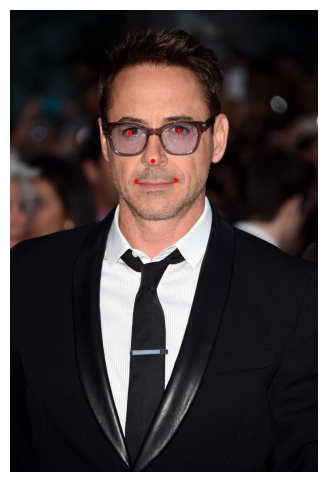

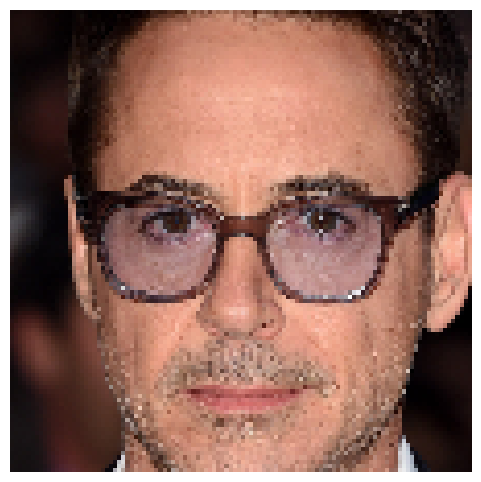

In [ ]:
image_path = "/content/Rec_dataset/Dataset/RDJ2.jpg"

img = cv2.imread(str(image_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

faces = app.get(img)
kps = faces[0].kps  # 5 landmarks

# crea una copia dell'immagine originale con punti segnati
img_points = img.copy()
for (x, y) in kps.astype(int):
    cv2.circle(img_points, (x, y), 10, (255, 0, 0), -1)

aligned = align_face(image_path)

#immagine originale
plt.figure(figsize=(6, 6))
plt.imshow(img_points)
plt.axis("off")
plt.show()

# immagine allineata
plt.figure(figsize=(6, 6))
plt.imshow(aligned)
plt.axis("off")
plt.show()


## ViT arcface

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model(
    "hf_hub:gaunernst/vit_tiny_patch8_112.arcface_ms1mv3",
    pretrained=True
).eval().to(device)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

In [ ]:
def get_embeddings(image_path):
    aligned = align_face(image_path)
    x = transform(aligned).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model(x)
        emb = F.normalize(emb, dim=1)
    return emb.squeeze(0).cpu()


In [ ]:
img1 = "/content/Rec_dataset/Dataset/DylanSprouse2.jpg"
img2 = "/content/Rec_dataset/Test/inter_personal/ColeSprouse.jpg" #different
#img2 = "/content/Rec_dataset/Dataset/KatyPerry3.jpg" #same

emb_al_1 = get_embeddings(img1)
emb_al_2 = get_embeddings(img2)

sim_aligned = F.cosine_similarity(emb_al_1, emb_al_2, dim=0).item()
print("Aligned similarity:", sim_aligned)


Aligned similarity: 0.6302089691162109


## Gallery (features extraction)

In [ ]:
def build_gallery(gallery_path):
    gallery_embeddings = defaultdict(list)
    valid_ext = ["*.jpg", "*.jpeg", "*.png"]

    img_paths = []
    for ext in valid_ext:
        img_paths.extend(gallery_path.glob(ext))

    for img_path in tqdm(img_paths, desc="Building gallery"):

        identity = ''.join([c for c in img_path.stem if not c.isdigit()])

        try:
            emb = get_embeddings(img_path)  #alignment
            gallery_embeddings[identity].append(emb)

        except ValueError as e:
            print(f"⚠️ Skipping {img_path.name}: {e}")
            continue

    print(f"\nLoaded {len(gallery_embeddings)} identities.")
    return gallery_embeddings


gallery_embeddings = build_gallery(gallery_path)

Building gallery:  16%|█▌        | 34/212 [00:26<01:31,  1.94it/s]

⚠️ Skipping JeffreyDeanMorgan1.jpg: No face detected in /content/Rec_dataset/Dataset/JeffreyDeanMorgan1.jpg


Building gallery:  87%|████████▋ | 184/212 [02:03<00:18,  1.53it/s]

⚠️ Skipping RDJ3.jpg: No face detected in /content/Rec_dataset/Dataset/RDJ3.jpg


Building gallery: 100%|██████████| 212/212 [02:21<00:00,  1.50it/s]


Loaded 72 identities.


In [ ]:
for name, templates in gallery_embeddings.items():
    print(name, len(templates))


MatthewMcConaughey 3
PattyPravo 3
ElizabethOlsen 3
LeonardoDiCaprio 3
ClintEastwood 3
JenniferLawrence 3
DylanSprouse 3
JeffreyDeanMorgan 2
HarryStyles 3
MargotRobbie 3
TrixieMattel 3
NicoleKidman 3
Rupaul 1
RuPaul 2
SachaBaronCohen 3
KatyPerry 3
ZoeSaldana 3
MonicaBellucci 3
KevinJonas 3
Platinette 3
OliverPhelps 3
DonaldTrump 3
QueenElizabeth 3
RDJ 2
AntonioBanderas 3
ZacEfron 3
JimCarrey 3
DanielRadcliffe 3
JamesCharles 3
AdamSandler 3
EddieRedmayne 3
IlaryBlasi 3
MacaulayCulkin 3
DaxShepard 3
MegRyan 3
LiamHemsworth 3
RobertDeNiro 3
GiorgiaMeloni 3
JessicaChastain 3
GeorgeClooney 3
SimonaVentura 3
MarlonBrando 3
ScarlettJohansson 3
KylieJenner 3
DojaCat 3
JohnnyDepp 3
KeanuReeves 3
BritneySpears 3
BradPitt 3
GiorgioChiellini 3
LindsayLohan 2
RamiMalek 3
JaimePressly 3
LoredanaBerte 3
EmmaWatson 3
Adele 3
NickJonas 3
WillemDafoe 3
AshleyOlsen 3
OrnellaVanoni 3
JoeJonas 3
GlenPowell 3
ChrisEvans 3
JoeBiden 3
RobinWilliams 3
ChrisHemsworth 3
HughGrant 3
BruceJenner 3
KimKardashian 3
D

## Face verification

In [ ]:
def evaluate_thresholds_to_csv(category, thresholds, csv_path):
    """
    Evaluates verification metrics across a list of thresholds for a given category.
    Results are saved into a CSV file.

    Parameters:
        category (str): Name of the test subset (e.g., 'age', 'makeup', ...).
        thresholds (list): List of numeric threshold values to evaluate.
        csv_path (str): Output CSV file path.
    """

    # Folder containing the probe images for this category
    test_folder = test_path / category
    valid_ext = ["*.jpg", "*.jpeg", "*.png"]

    # Collect all probe image paths
    probe_paths = []
    for ext in valid_ext:
        probe_paths.extend(test_folder.glob(ext))

    # CSV header
    rows = [["threshold", "GA", "FR", "FA", "GR", "FAR", "FRR", "GAR", "GRR"]]

    # Loop over all thresholds
    for threshold in tqdm(thresholds, desc=f"Thresholds {category}"):

        # GA = Genuine Accept
        # FR = False Reject
        # FA = False Accept
        # GR = Genuine Reject (correct impostor non-matches)
        GA = FR = FA = GR = 0

        # Loop over all probe images
        for probe_path in probe_paths:

            probe_name = probe_path.stem.lower()  # exact name of the subject

            # Compute the embedding of the probe image
            try:
                probe_emb = get_embeddings(probe_path)
            except Exception as e:
                print(f"⚠️ Skipping probe {probe_path.name}: {e}")
                continue

            # Compare probe with all gallery identities
            for gallery_name, template_list in gallery_embeddings.items():

                gallery_name_clean = gallery_name.lower()

                if len(template_list) == 0:
                    continue  # skip identities without templates

                # Compute similarity with all templates of this identity
                try:
                    sims = [
                        F.cosine_similarity(probe_emb, t, dim=0).item()
                        for t in template_list
                    ]
                except Exception as e:
                    print(f"⚠️ Skipping comparison {probe_path.name} vs {gallery_name}: {e}")
                    continue

                max_sim = max(sims)

                # Determine if this comparison is genuine or impostor
                is_genuine = (gallery_name_clean == probe_name)

                # Check match based on current threshold
                match = (max_sim >= threshold)

                # Update the confusion matrix counters
                if match and is_genuine:
                    GA += 1  # Genuine Accept
                if match and not is_genuine:
                    FA += 1  # False Accept
                if not match and is_genuine:
                    FR += 1  # False Reject
                if not match and not is_genuine:
                    GR += 1  # Genuine Reject

        # Compute metrics for this threshold
        FAR = FA / (FA + GR) if (FA + GR) else 0
        FRR = FR / (FR + GA) if (FR + GA) else 0
        GAR = 1 - FRR
        GRR = 1 - FAR

        # Append results to CSV rows
        rows.append([threshold, GA, FR, FA, GR, FAR, FRR, GAR, GRR])

    # Save CSV
    with open(csv_path, "w", newline="") as f:
        csv.writer(f).writerows(rows)

    print(f"Saved metrics to {csv_path}")


In [ ]:
thresholds = np.arange(0, 1.05, 0.05)

output_dir = "/content/drive/MyDrive/Biometric systems/CSV1/"
categories = [
    "age",
    "camouflage",
    "deep_fake",
    "inter_personal",
    "make_up",
    "plastic_surgery",
    "print_attack"
]

for cat in categories:
    csv_path = f"{output_dir}/{cat}.csv"
    print(f"\n=== Processing category: {cat} ===")

    evaluate_thresholds_to_csv(
        category=cat,
        thresholds=thresholds,
        csv_path=csv_path
    )


=== Processing category: age ===


Thresholds age: 100%|██████████| 21/21 [03:05<00:00,  8.83s/it]


Saved metrics to /content/drive/MyDrive/Biometric systems/CSV1//age.csv

=== Processing category: camouflage ===


Thresholds camouflage: 100%|██████████| 21/21 [02:50<00:00,  8.12s/it]


Saved metrics to /content/drive/MyDrive/Biometric systems/CSV1//camouflage.csv

=== Processing category: deep_fake ===


Thresholds deep_fake:   0%|          | 0/21 [00:00<?, ?it/s]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:   5%|▍         | 1/21 [00:07<02:28,  7.42s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  10%|▉         | 2/21 [00:14<02:17,  7.23s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  14%|█▍        | 3/21 [00:21<02:10,  7.27s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  19%|█▉        | 4/21 [00:29<02:04,  7.31s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  24%|██▍       | 5/21 [00:36<01:56,  7.29s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  29%|██▊       | 6/21 [00:44<01:50,  7.38s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  33%|███▎      | 7/21 [00:51<01:41,  7.25s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  38%|███▊      | 8/21 [00:58<01:34,  7.31s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  43%|████▎     | 9/21 [01:05<01:28,  7.35s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  48%|████▊     | 10/21 [01:13<01:20,  7.30s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  52%|█████▏    | 11/21 [01:20<01:13,  7.32s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  57%|█████▋    | 12/21 [01:27<01:05,  7.23s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  62%|██████▏   | 13/21 [01:34<00:58,  7.32s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  67%|██████▋   | 14/21 [01:42<00:51,  7.34s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  71%|███████▏  | 15/21 [01:49<00:43,  7.25s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  76%|███████▌  | 16/21 [01:56<00:36,  7.33s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  81%|████████  | 17/21 [02:03<00:28,  7.23s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  86%|████████▌ | 18/21 [02:11<00:21,  7.30s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  90%|█████████ | 19/21 [02:18<00:14,  7.37s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake:  95%|█████████▌| 20/21 [02:26<00:07,  7.31s/it]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Thresholds deep_fake: 100%|██████████| 21/21 [02:33<00:00,  7.32s/it]


Saved metrics to /content/drive/MyDrive/Biometric systems/CSV1//deep_fake.csv

=== Processing category: inter_personal ===


Thresholds inter_personal: 100%|██████████| 21/21 [06:24<00:00, 18.29s/it]


Saved metrics to /content/drive/MyDrive/Biometric systems/CSV1//inter_personal.csv

=== Processing category: make_up ===


Thresholds make_up: 100%|██████████| 21/21 [02:45<00:00,  7.89s/it]


Saved metrics to /content/drive/MyDrive/Biometric systems/CSV1//make_up.csv

=== Processing category: plastic_surgery ===


Thresholds plastic_surgery: 100%|██████████| 21/21 [03:28<00:00,  9.94s/it]


Saved metrics to /content/drive/MyDrive/Biometric systems/CSV1//plastic_surgery.csv

=== Processing category: print_attack ===


Thresholds print_attack: 100%|██████████| 21/21 [02:40<00:00,  7.66s/it]

Saved metrics to /content/drive/MyDrive/Biometric systems/CSV1//print_attack.csv


In [ ]:
def save_similarities_txt(category, txt_path):

    test_folder = test_path / category
    valid_ext = ["*.jpg", "*.jpeg", "*.png"]

    probe_paths = []
    for ext in valid_ext:
        probe_paths.extend(test_folder.glob(ext))

    with open(txt_path, "w") as f:
        f.write("probe,gallery,template_idx,similarity,is_genuine\n")

        for probe_path in tqdm(probe_paths, desc=f"Similarities {category}"):

            probe_name = ''.join([c for c in probe_path.stem if not c.isdigit()])

            try:
                probe_emb = get_embeddings(probe_path).cpu()
            except Exception as e:
                print(f"⚠️ Skipping probe {probe_path.name}: {e}")
                continue

            for gallery_name, template_list in gallery_embeddings.items():

                is_genuine = int(gallery_name.lower() == probe_name.lower())

                for idx, g_emb in enumerate(template_list):

                    try:
                        sim = F.cosine_similarity(probe_emb, g_emb.cpu(), dim=0).item()
                    except Exception as e:
                        print(f"⚠️ Skipping similarity {probe_path.name} vs {gallery_name}: {e}")
                        continue

                    f.write(f"{probe_path.name},{gallery_name},{idx},{sim},{is_genuine}\n")

    print(f"Saved similarities to {txt_path}")


In [ ]:
categories = [
    "age", "camouflage", "deep_fake",
    "inter_personal", "make_up",
    "plastic_surgery", "print_attack"
]

for cat in categories:
    save_similarities_txt(
        category=cat,
        txt_path=f"/content/drive/MyDrive/Biometric systems/TXT1/sims_{cat}.txt"
    )


Similarities age: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Saved similarities to /content/drive/MyDrive/Biometric systems/TXT1/sims_age.txt


Similarities camouflage: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Saved similarities to /content/drive/MyDrive/Biometric systems/TXT1/sims_camouflage.txt


Similarities deep_fake:  42%|████▏     | 5/12 [00:02<00:03,  1.86it/s]

⚠️ Skipping probe LeonardoDiCaprio.jpg: No face detected in /content/Rec_dataset/Test/deep_fake/LeonardoDiCaprio.jpg


Similarities deep_fake: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Saved similarities to /content/drive/MyDrive/Biometric systems/TXT1/sims_deep_fake.txt


Similarities inter_personal: 100%|██████████| 27/27 [00:18<00:00,  1.48it/s]


Saved similarities to /content/drive/MyDrive/Biometric systems/TXT1/sims_inter_personal.txt


Similarities make_up: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Saved similarities to /content/drive/MyDrive/Biometric systems/TXT1/sims_make_up.txt


Similarities plastic_surgery: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


Saved similarities to /content/drive/MyDrive/Biometric systems/TXT1/sims_plastic_surgery.txt


Similarities print_attack: 100%|██████████| 12/12 [00:07<00:00,  1.50it/s]

Saved similarities to /content/drive/MyDrive/Biometric systems/TXT1/sims_print_attack.txt


# Evaluation


CATEGORY: AGE



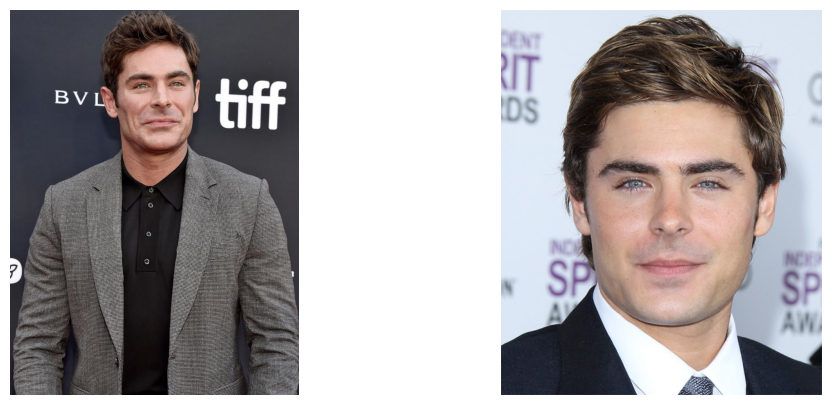

BEST MATCH: ZacEfron | similarity = 0.7523



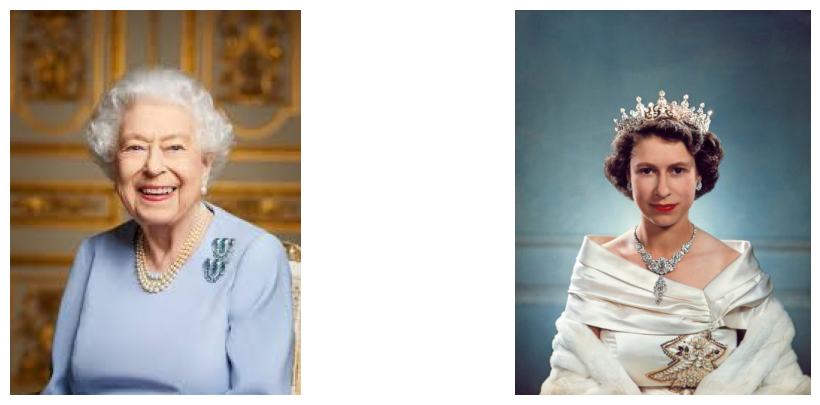

WORST MATCH: QueenElizabeth | similarity = 0.2571

------------------------------------------------------------


CATEGORY: CAMOUFLAGE



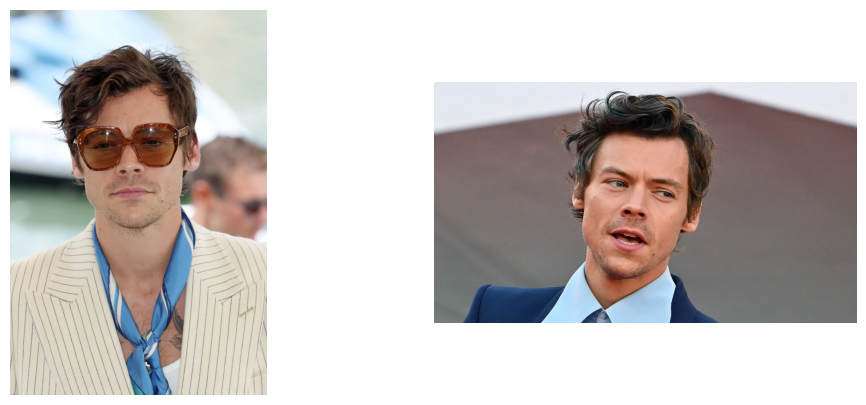

BEST MATCH: HarryStyles | similarity = 0.6961



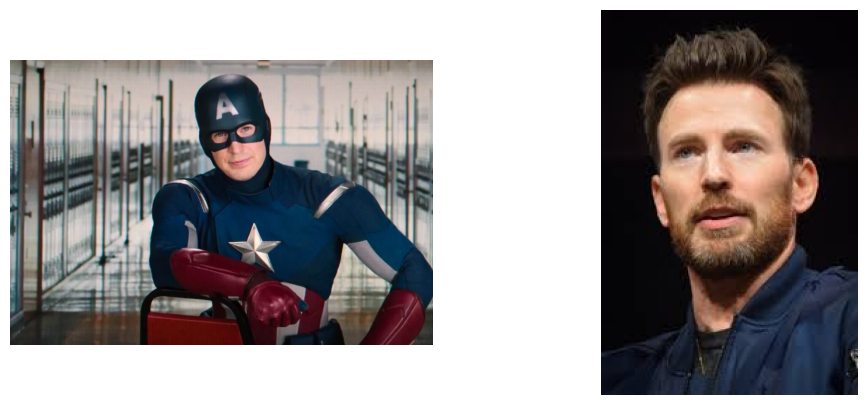

WORST MATCH: ChrisEvans | similarity = 0.3594

------------------------------------------------------------


CATEGORY: DEEP_FAKE



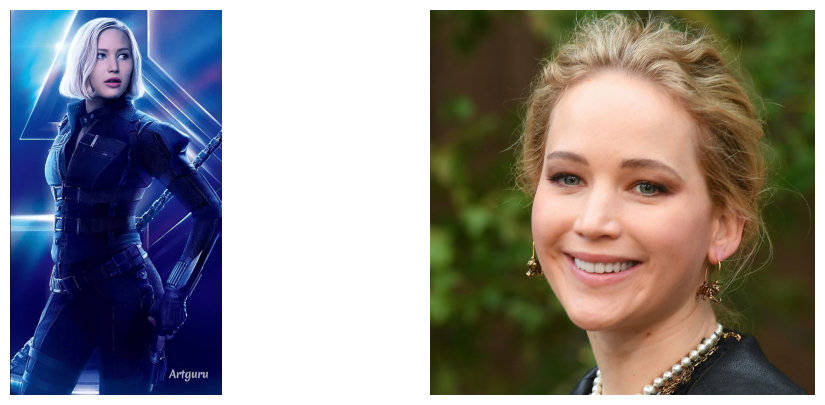

BEST MATCH: JenniferLawrence | similarity = 0.8292



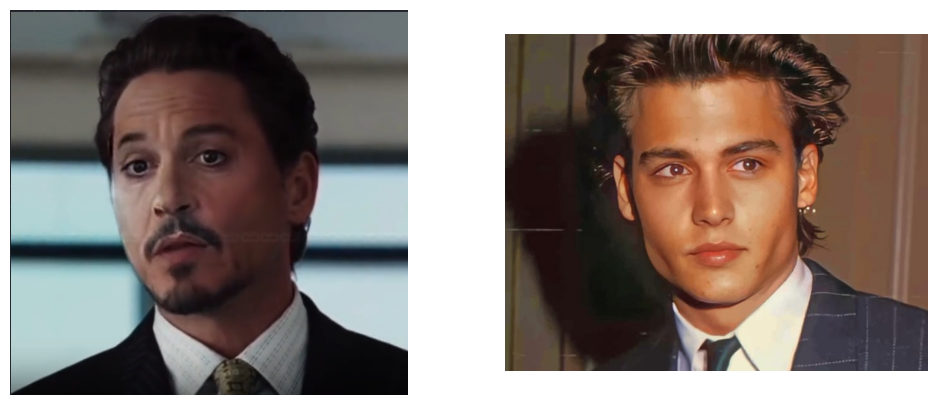

WORST MATCH: JohnnyDepp | similarity = 0.2182

------------------------------------------------------------


CATEGORY: INTER_PERSONAL



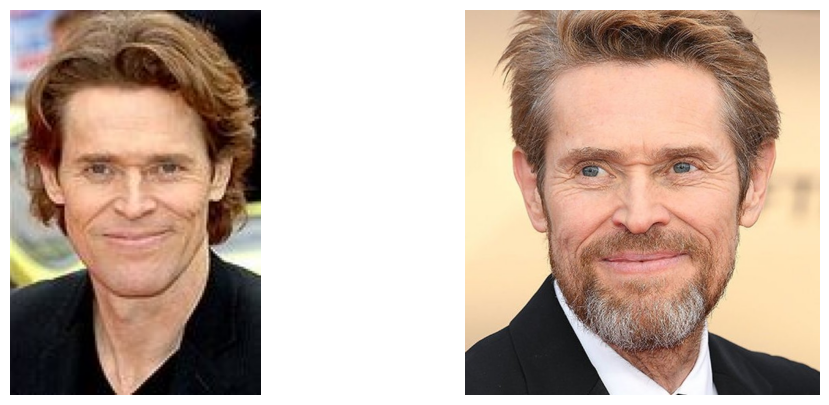

BEST MATCH: WillemDafoe | similarity = 0.8772



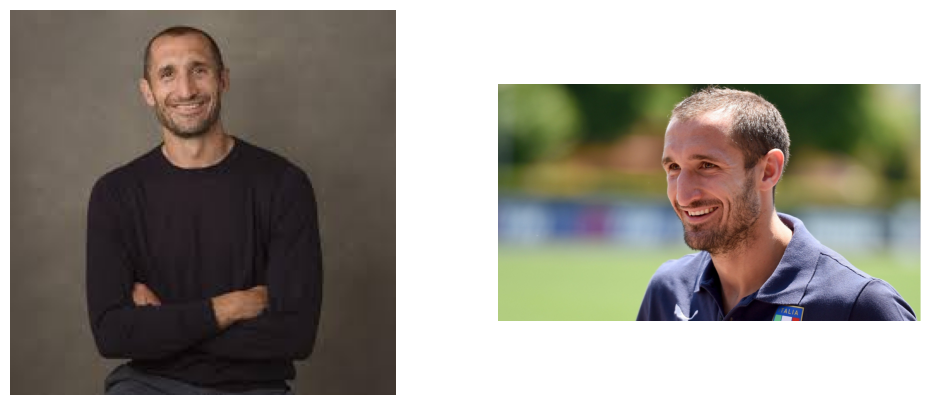

WORST MATCH: GiorgioChiellini | similarity = 0.5682

------------------------------------------------------------


CATEGORY: MAKE_UP



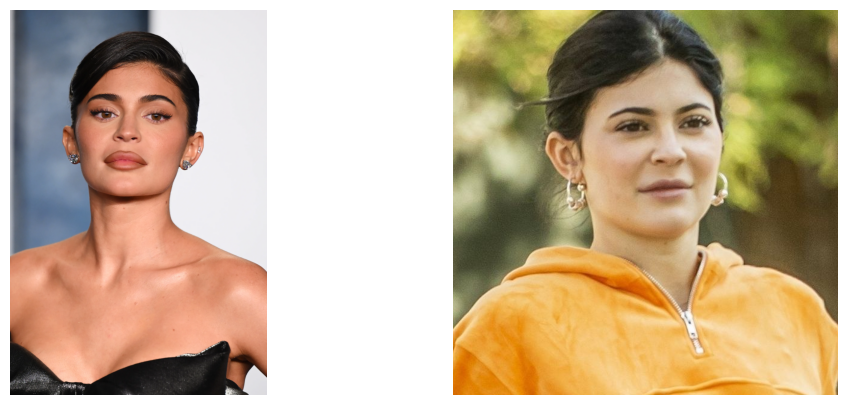

BEST MATCH: KylieJenner | similarity = 0.6662



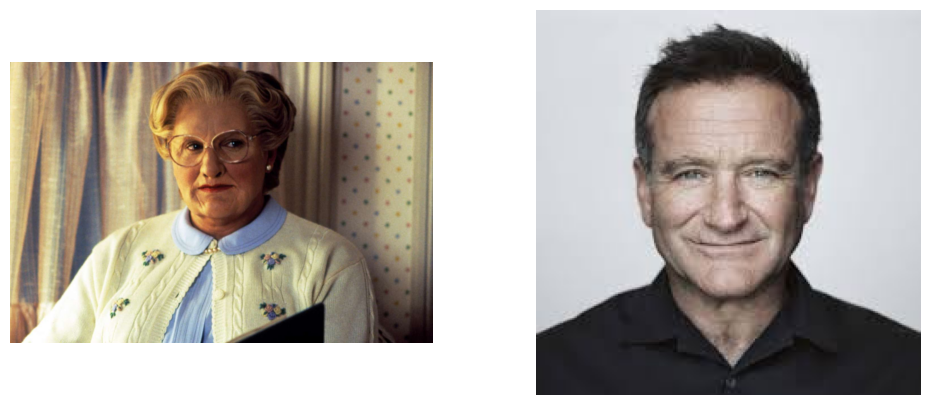

WORST MATCH: RobinWilliams | similarity = 0.0232

------------------------------------------------------------


CATEGORY: PLASTIC_SURGERY



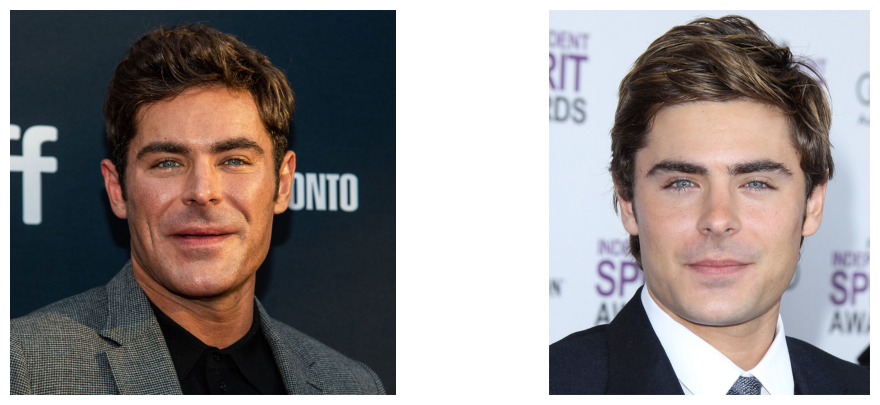

BEST MATCH: ZacEfron | similarity = 0.7205



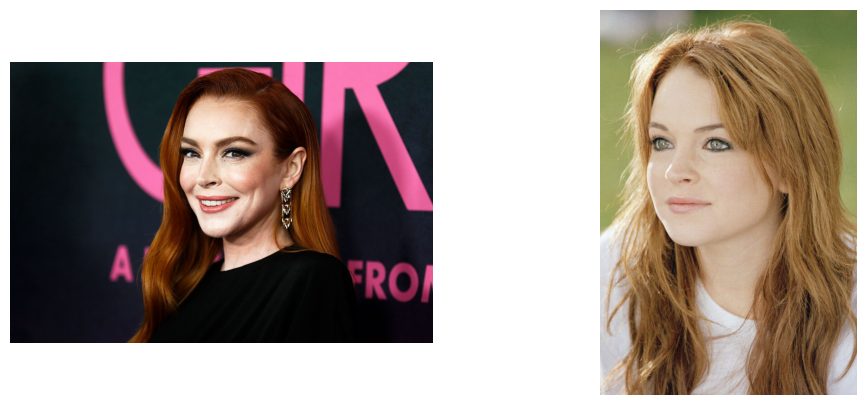

WORST MATCH: LindsayLohan | similarity = 0.1889

------------------------------------------------------------


CATEGORY: PRINT_ATTACK



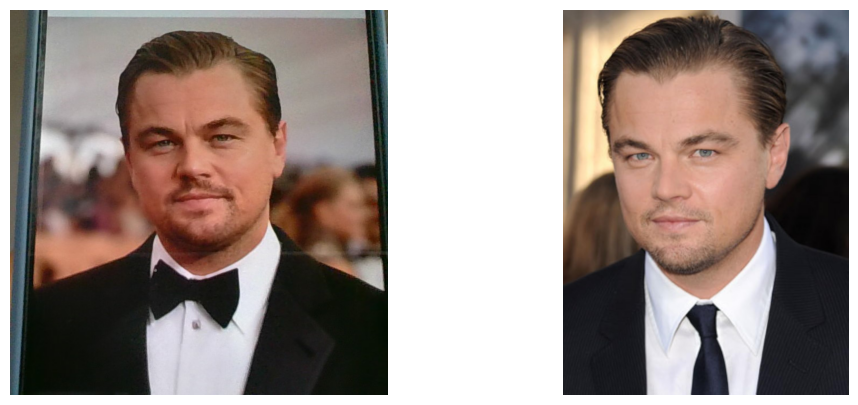

BEST MATCH: LeonardoDiCaprio | similarity = 0.8629



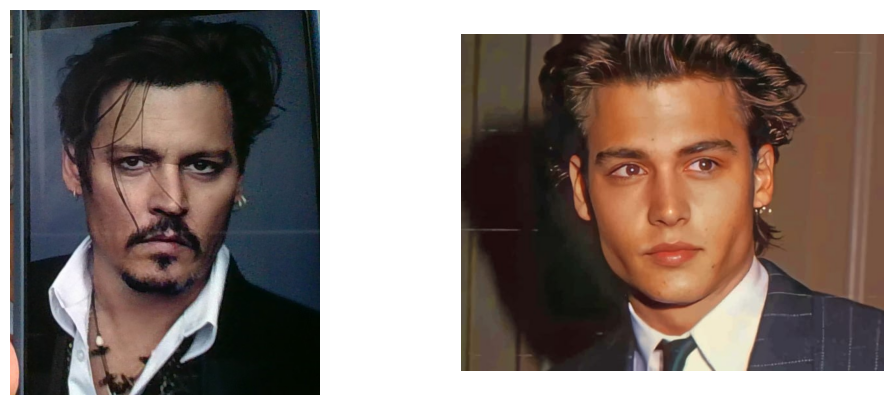

WORST MATCH: JohnnyDepp | similarity = 0.4295

------------------------------------------------------------



In [ ]:
def show_best_and_worst(category, sims_path, test_root, gallery_root):

    df = pd.read_csv(sims_path)
    df = df[df["is_genuine"] == 1]

    best_row = df.loc[df["similarity"].idxmax()]
    worst_row = df.loc[df["similarity"].idxmin()]

    # Percorsi
    probe_best_path  = Path(test_root) / category / best_row["probe"]
    probe_worst_path = Path(test_root) / category / worst_row["probe"]

    gallery_best_path  = list(Path(gallery_root).glob(f"{best_row['gallery']}*.jpg"))[0]
    gallery_worst_path = list(Path(gallery_root).glob(f"{worst_row['gallery']}*.jpg"))[0]

    print("\n=====================================")
    print(f"CATEGORY: {category.upper()}")
    print("=====================================\n")

    # BEST
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].imshow(Image.open(probe_best_path))
    ax[0].axis("off")

    ax[1].imshow(Image.open(gallery_best_path))
    ax[1].axis("off")

    plt.show()

    print(f"BEST MATCH: {best_row['gallery']} | similarity = {best_row['similarity']:.4f}\n")


    # WORST
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].imshow(Image.open(probe_worst_path))
    ax[0].axis("off")

    ax[1].imshow(Image.open(gallery_worst_path))
    ax[1].axis("off")

    plt.show()

    print(f"WORST MATCH: {worst_row['gallery']} | similarity = {worst_row['similarity']:.4f}\n")

    print("------------------------------------------------------------\n")


categories = [
    "age", "camouflage", "deep_fake",
    "inter_personal", "make_up",
    "plastic_surgery", "print_attack"
]

for cat in categories:
    sims_file = f"/content/drive/MyDrive/Biometric systems/TXT1/sims_{cat}.txt"
    show_best_and_worst(cat, sims_file, test_path, gallery_path)


In [ ]:
def analyze_biometric_csv(csv_path, label="category"):

    # CSV
    df = pd.read_csv(csv_path)

    thresholds = df["threshold"].values
    FAR = df["FAR"].values
    FRR = df["FRR"].values

    #Calcolo EER
    diff = np.abs(FAR - FRR)
    eer_idx = np.argmin(diff)

    eer_threshold = thresholds[eer_idx]
    eer_value = (FAR[eer_idx] + FRR[eer_idx]) / 2
    margin = FAR - FRR
    margin_at_eer = margin[eer_idx]

    print(f"[{label}] EER ≈ {eer_value:.4f} a soglia ≈ {eer_threshold:.4f}")
    print(f"[{label}] Margin alla soglia di EER: {margin_at_eer:.4f}")

    #FAR–FRR Plot
    plt.figure()
    plt.plot(thresholds, FAR, label="FAR")
    plt.plot(thresholds, FRR, label="FRR")
    plt.scatter(eer_threshold, eer_value, marker="o")
    plt.axvline(eer_threshold, linestyle="--", label=f"EER thr ≈ {eer_threshold:.3f}")
    plt.axhline(eer_value, linestyle="--", label=f"EER ≈ {eer_value:.3f}")
    plt.xlabel("Threshold")
    plt.ylabel("Rate")
    plt.title(f"FAR e FRR vs Threshold — {label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{label}_far_frr.png")
    plt.close()

    #Margin Plot
    plt.figure()
    plt.plot(thresholds, margin)
    plt.axvline(eer_threshold, linestyle="--", label="EER threshold")
    plt.xlabel("Threshold")
    plt.ylabel("FAR - FRR")
    plt.title(f"Margin (FAR - FRR) vs Threshold — {label}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{label}_margin.png")
    plt.close()

    # ROC Curve
    GAR = 1 - FRR
    plt.figure()
    plt.plot(FAR, GAR, label="ROC curve")
    plt.xlabel("FAR")
    plt.ylabel("GAR")
    plt.title(f"ROC Curve — {label}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{label}_roc.png")
    plt.close()

    # DET Curve
    plt.figure()
    plt.plot(FAR, FRR, label="DET curve")
    plt.xlabel("FAR")
    plt.ylabel("FRR")
    plt.title(f"DET Curve — {label}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{label}_det.png")
    plt.close()

    return {
        "EER": eer_value,
        "EER_threshold": eer_threshold,
        "margin_at_eer": margin_at_eer
    }


## Age

EER ≈ 0.0023 a soglia ≈ 0.3000
Margin alla soglia di EER: 0.0047


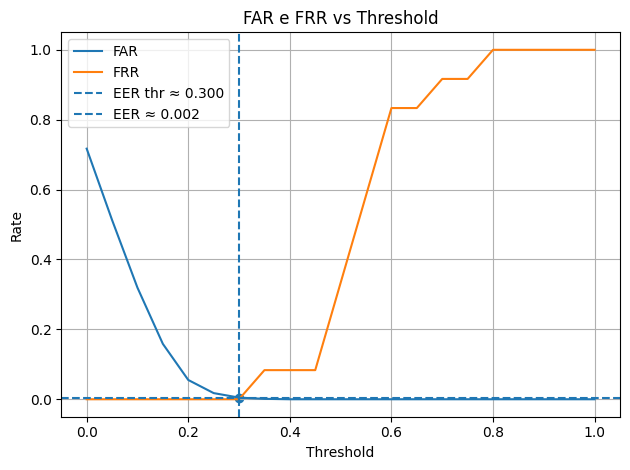

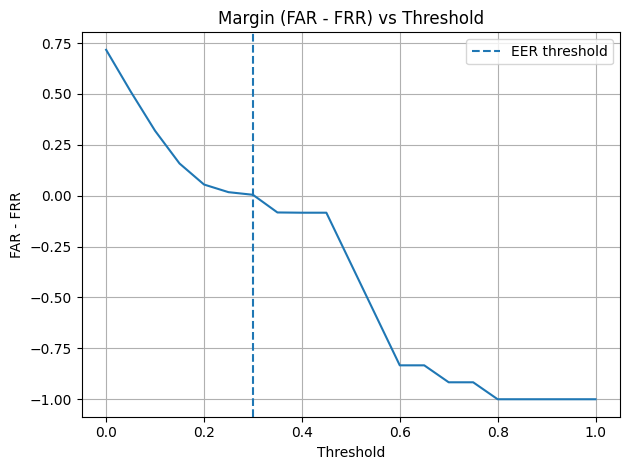

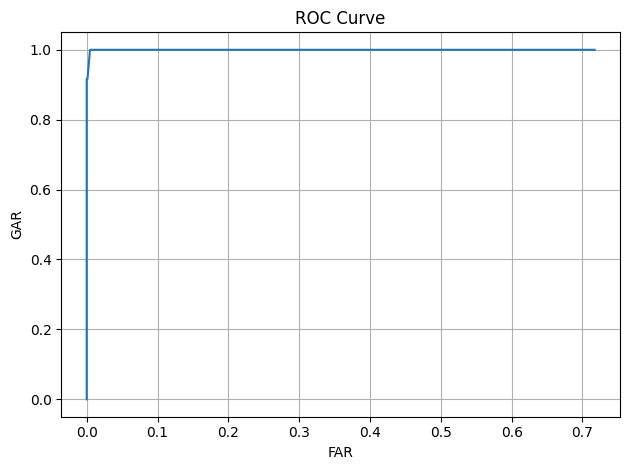

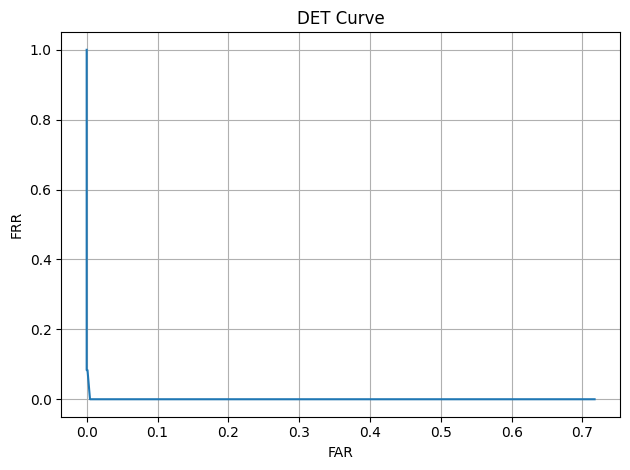

In [ ]:
res = analyze_biometric_csv(
    "/content/drive/MyDrive/Biometric systems/CSV1/age.csv",
    label="age"
)

## camouflage

Index(['threshold', 'GA', 'FR', 'FA', 'GR', 'FAR', 'FRR', 'GAR', 'GRR'], dtype='object')
EER ≈ 0.0000 a soglia ≈ 0.4000
Margin alla soglia di EER: 0.0000


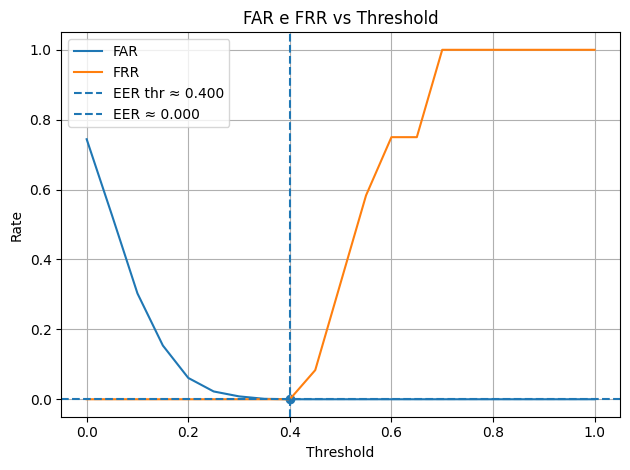

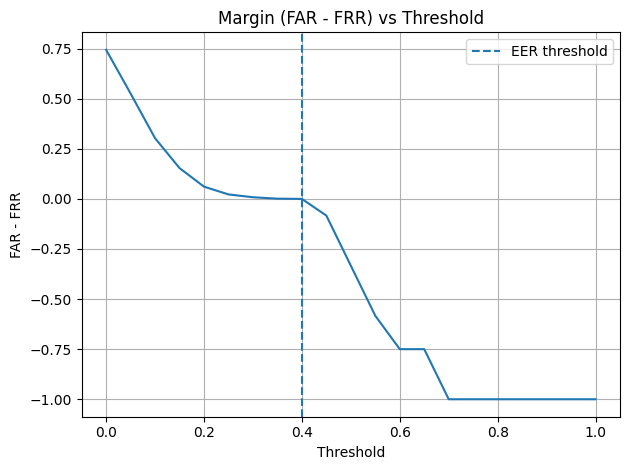

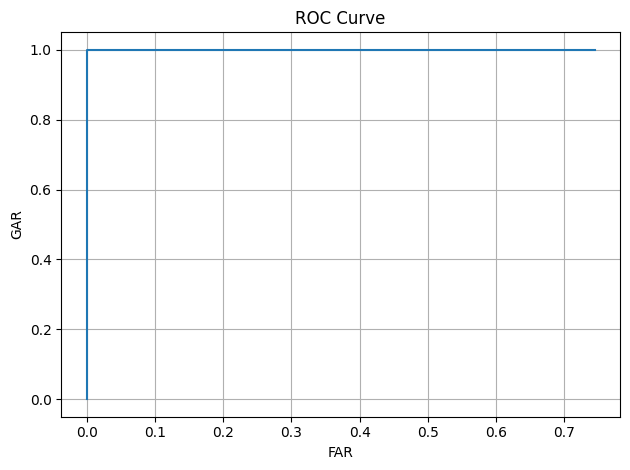

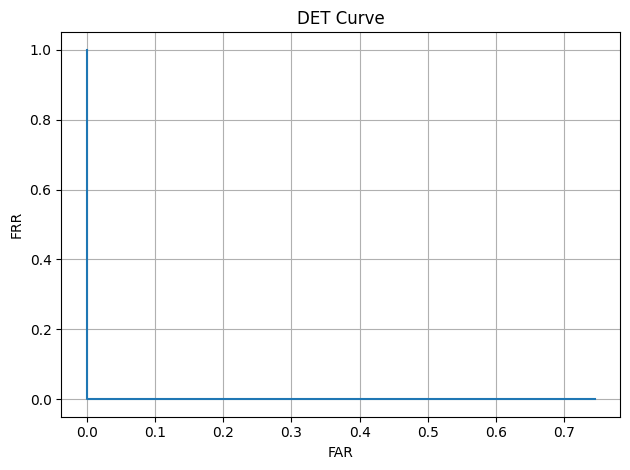

In [ ]:
res = analyze_biometric_csv(
    "/content/drive/MyDrive/Biometric systems/CSV1/camouflage.csv",
    label="age"
)


## Make-up

Index(['threshold', 'GA', 'FR', 'FA', 'GR', 'FAR', 'FRR', 'GAR', 'GRR'], dtype='object')
EER ≈ 0.1002 a soglia ≈ 0.1500
Margin alla soglia di EER: 0.0465


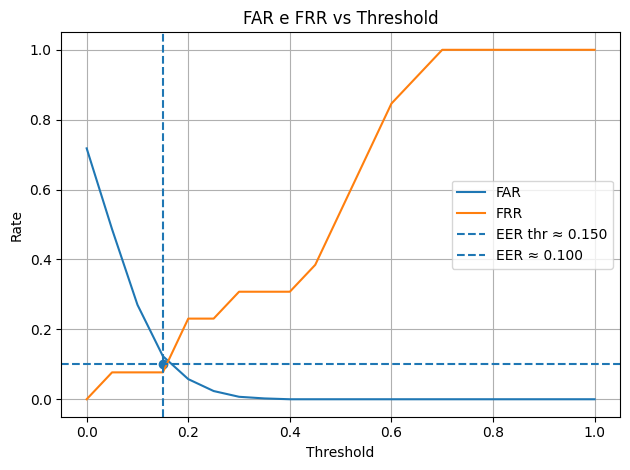

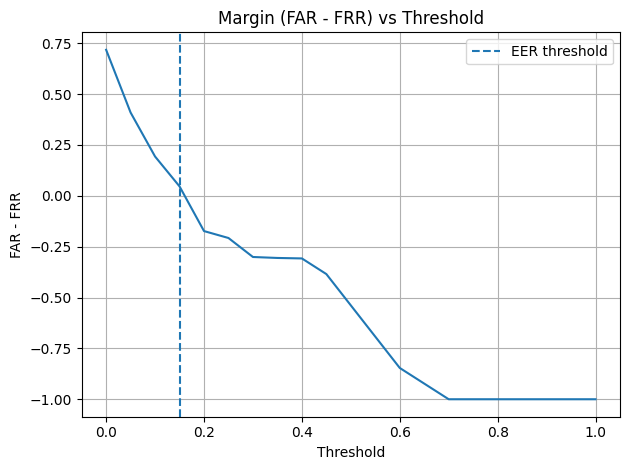

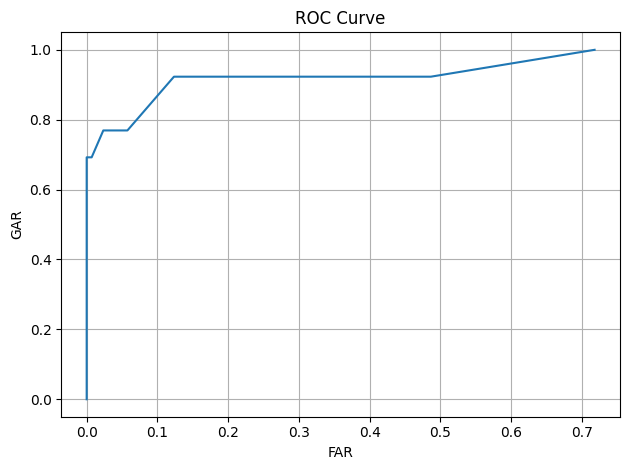

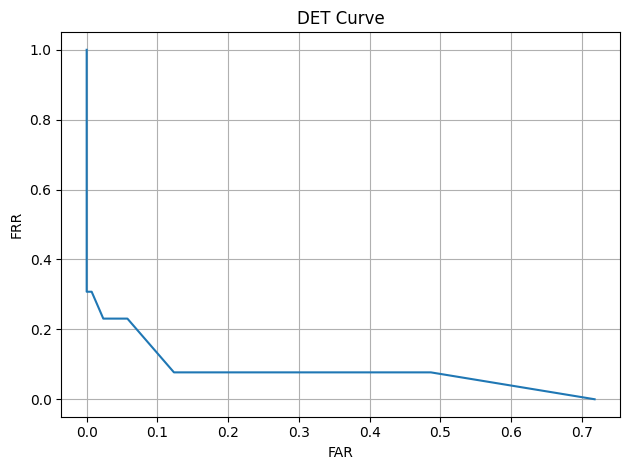

In [ ]:
res = analyze_biometric_csv(
    "/content/drive/MyDrive/Biometric systems/CSV1/make_up.csv",
    label="age"
)

## Plastic Surgery

Index(['threshold', 'GA', 'FR', 'FA', 'GR', 'FAR', 'FRR', 'GAR', 'GRR'], dtype='object')
EER ≈ 0.0123 a soglia ≈ 0.2500
Margin alla soglia di EER: 0.0246


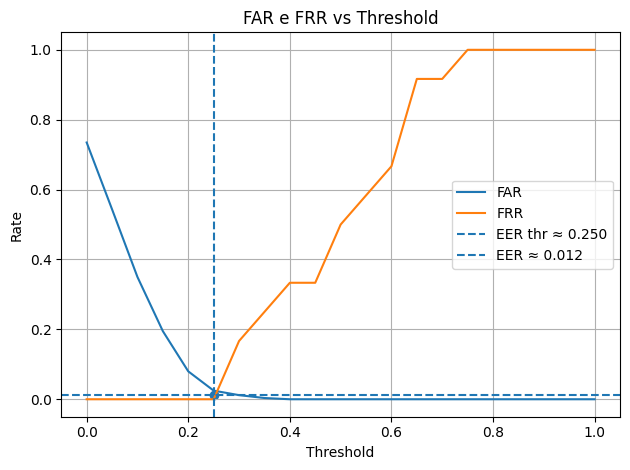

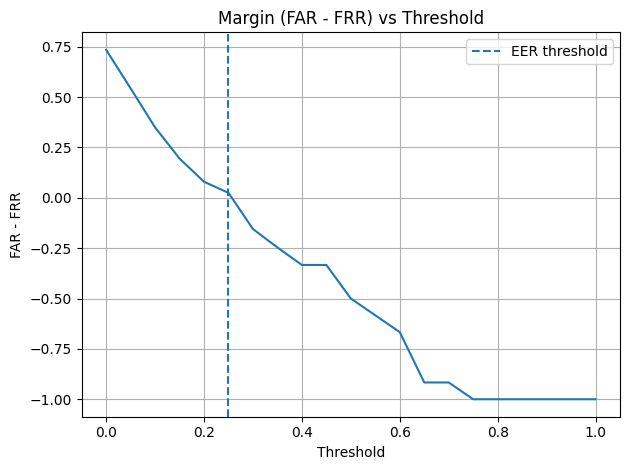

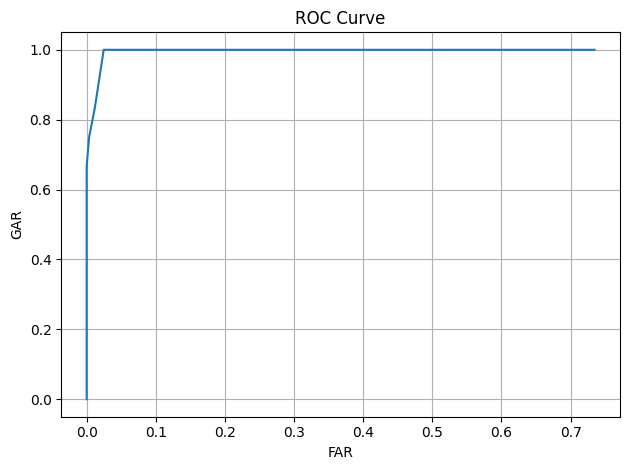

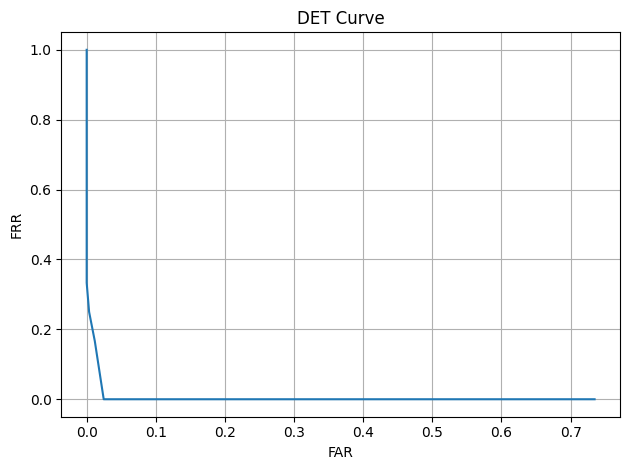

In [ ]:
res = analyze_biometric_csv(
    "/content/drive/MyDrive/Biometric systems/CSV1/plastic_surgery.csv",
    label="age"
)

## Interpersonal

Index(['threshold', 'GA', 'FR', 'FA', 'GR', 'FAR', 'FRR', 'GAR', 'GRR'], dtype='object')
EER ≈ 0.0005 a soglia ≈ 0.7000
Margin alla soglia di EER: 0.0010


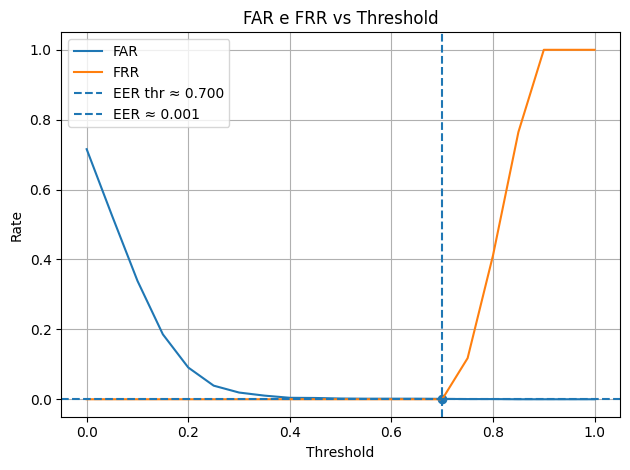

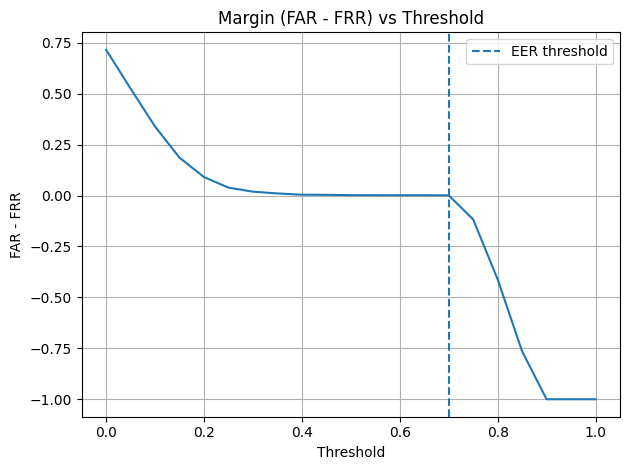

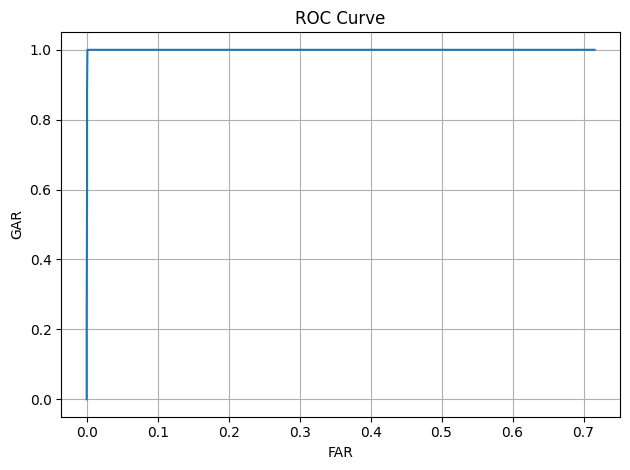

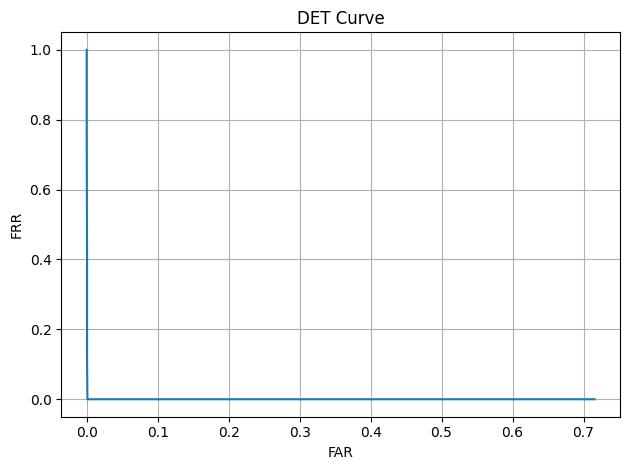

In [ ]:
res = analyze_biometric_csv(
    "/content/drive/MyDrive/Biometric systems/CSV1/inter_personal.csv",
    label="age"
)

## Deep fake

Index(['threshold', 'GA', 'FR', 'FA', 'GR', 'FAR', 'FRR', 'GAR', 'GRR'], dtype='object')
EER ≈ 0.0006 a soglia ≈ 0.4000
Margin alla soglia di EER: 0.0013


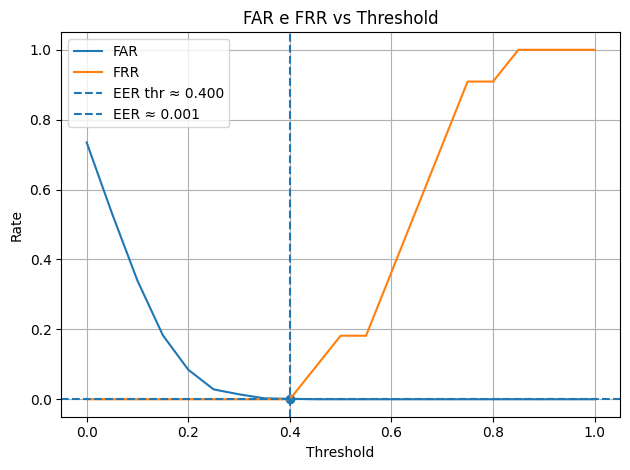

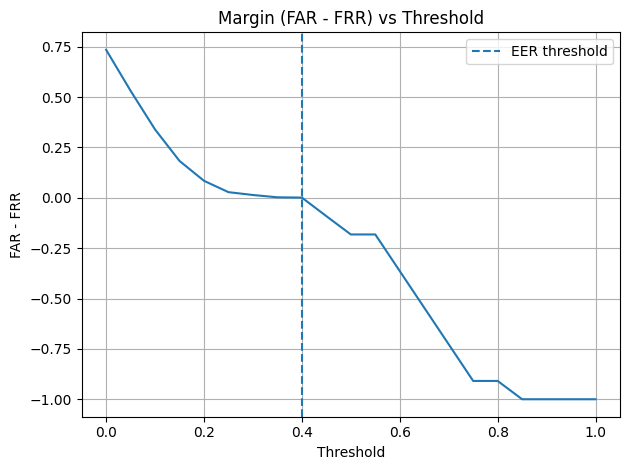

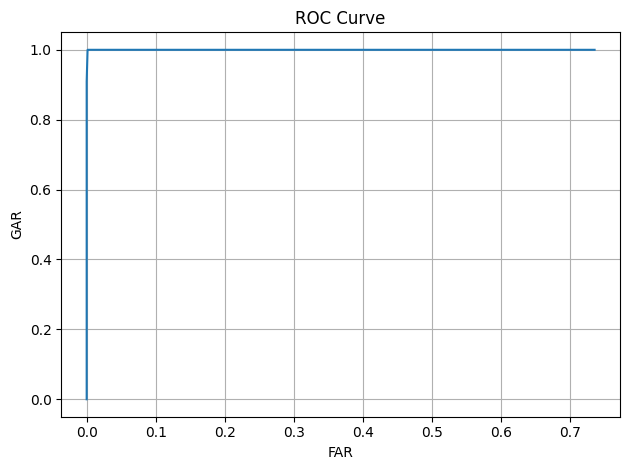

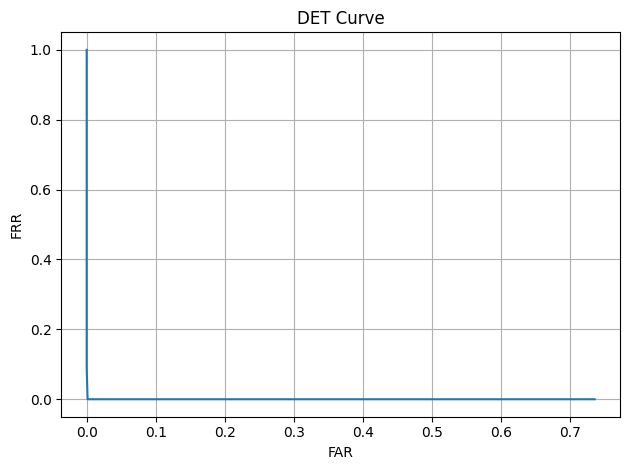

In [ ]:
res = analyze_biometric_csv(
    "/content/drive/MyDrive/Biometric systems/CSV1/deep_fake.csv",
    label="age"
)

## Print attack

Index(['threshold', 'GA', 'FR', 'FA', 'GR', 'FAR', 'FRR', 'GAR', 'GRR'], dtype='object')
EER ≈ 0.0000 a soglia ≈ 0.5000
Margin alla soglia di EER: 0.0000


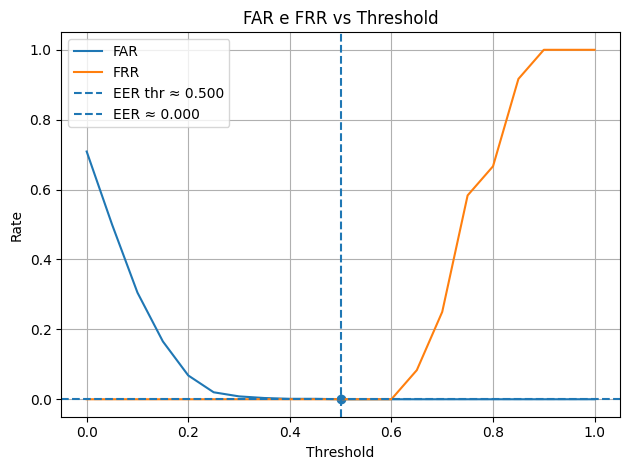

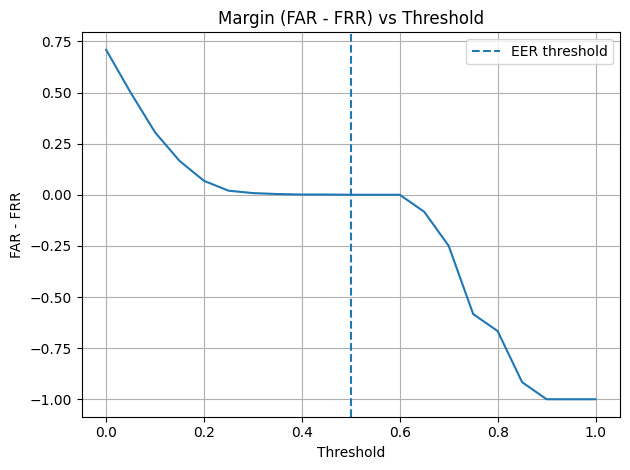

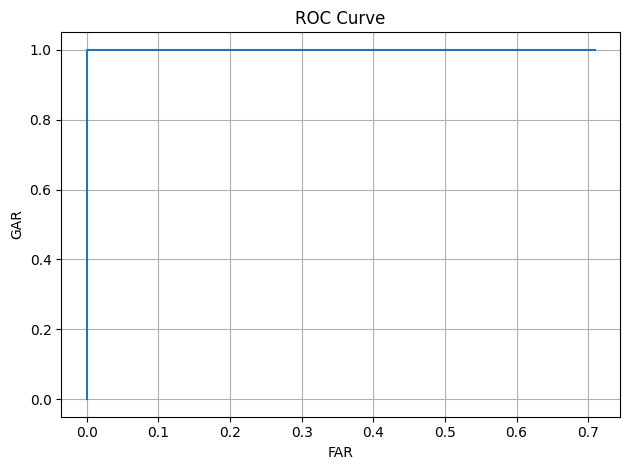

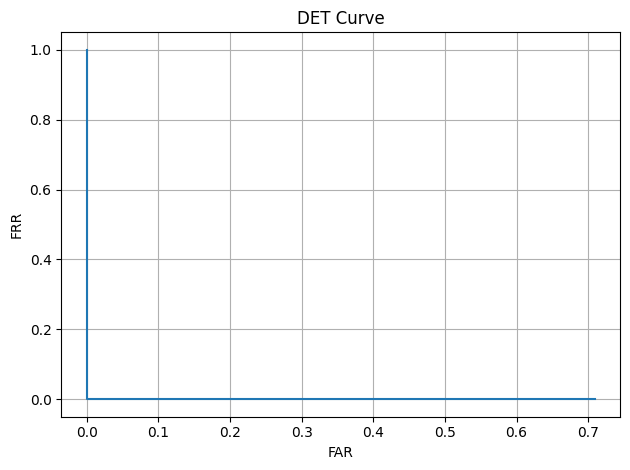

In [ ]:
res = analyze_biometric_csv(
    "/content/drive/MyDrive/Biometric systems/CSV1/print_attack.csv",
    label="age"
)